In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()

In [2]:
# Function for legible graphs (set dimensions and increase label font sizes)
def legible_graph(x, y):
    sns.set(rc={'figure.figsize':(x, y)})
    plt.rc('axes', titlesize=24) # Fontsize of title
    plt.rc('axes', labelsize=20) # Fontsize of x and y labels
    plt.rc('xtick', labelsize=16) # Fontsize of tick labels
    plt.rc('ytick', labelsize=16)
    plt.rc('legend', fontsize=14)
    
# Function to label title and axes, and to specify if want logy scale
def set_labels(title, xlabel, ylabel, logy=False):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if logy:
        plt.yscale('log')

# Initial data processing
- Extrapolated remaining weeks of flu season based on 2017-2018 data
- Changed units from rates per 100,000 population to total number
- Changed from hospitalizations to estimated deaths

In [3]:
# Load influenza hospitalization data
# Source: https://gis.cdc.gov/GRASP/Fluview/FluHospRates.html
hospitalization = pd.read_csv("FluSurveillance 2017-2019.csv")

# Examine general format
hospitalization.head()

,MMWR-YEAR,MMWR-WEEK,DATE,CUMULATIVE RATE,WEEKLY RATE
0,2017,40,10/7/17,0.1,0.1
1,2017,41,10/14/17,0.2,0.1
2,2017,42,10/21/17,0.5,0.2
3,2017,43,10/28/17,0.7,0.2
4,2017,44,11/4/17,1.0,0.3


In [4]:
# Change year to specify flu season since it wraps from end of one year to beginning of the next
hospitalization.loc[(hospitalization['MMWR-YEAR']==2020) |\
                    (hospitalization['MMWR-YEAR']==2019) & (hospitalization['MMWR-WEEK']>=40), 'MMWR-YEAR'] = '2019-2020'

hospitalization.loc[(hospitalization['MMWR-YEAR']==2019) & (hospitalization['MMWR-WEEK']<40)|\
                    (hospitalization['MMWR-YEAR']==2018) & (hospitalization['MMWR-WEEK']>=40), 'MMWR-YEAR'] = '2018-2019'

hospitalization.loc[(hospitalization['MMWR-YEAR']==2018) & (hospitalization['MMWR-WEEK']<40)|\
                    (hospitalization['MMWR-YEAR']==2017) & (hospitalization['MMWR-WEEK']>=40), 'MMWR-YEAR'] = '2017-2018'

# Change to wide format with rates for each season along columns
wide_hosp = hospitalization.groupby(['MMWR-WEEK', 'MMWR-YEAR'])['DATE', 'CUMULATIVE RATE', 'WEEKLY RATE'].aggregate('first').unstack()

# Check formatting
wide_hosp.head()

DATE                     CUMULATIVE RATE                      \
MMWR-YEAR 2017-2018 2018-2019 2019-2020       2017-2018 2018-2019 2019-2020   
MMWR-WEEK                                                                     
1            1/6/18    1/5/19    1/4/20            30.5      11.6      18.9   
2           1/13/18   1/12/19   1/11/20            40.3      14.1      23.7   
3           1/20/18   1/19/19   1/18/20            49.2      16.3      28.1   
4           1/27/18   1/26/19   1/25/20            57.7      18.6      33.0   
5            2/3/18    2/2/19    2/1/20            65.5      21.6      38.6   

          WEEKLY RATE                      
MMWR-YEAR   2017-2018 2018-2019 2019-2020  
MMWR-WEEK                                  
1                10.2       3.0       5.5  
2                 9.8       2.5       4.8  
3                 8.9       2.1       4.4  
4                 8.5       2.3       4.9  
5                 7.8       3.0       5.6

In [5]:
# For remaining weeks in current year, estimate weekly rate by taking average of 2017-2018 and 2018-2019 data
wide_hosp.loc[12:17, ('WEEKLY RATE', '2019-2020')] = \
              wide_hosp.loc[12:17, [('WEEKLY RATE', '2017-2018'), ('WEEKLY RATE', '2018-2019')]].mean(axis=1)

# Check extrapolation was successful
wide_hosp.loc[12:17, ('WEEKLY RATE', '2019-2020')]

MMWR-WEEK
12    3.55
13    2.90
14    2.30
15    1.55
16    1.05
17    0.90
Name: (WEEKLY RATE, 2019-2020), dtype: float64

In [6]:
# New dataframe with only 2019-2020 data
current_year = wide_hosp.xs('2019-2020', level='MMWR-YEAR', axis=1).copy().reset_index()

# Create week index to account for end of one year wrapping into the next
current_year.loc[current_year['MMWR-WEEK'] >= 40, 'WEEK'] = current_year['MMWR-WEEK']-39
current_year.loc[current_year['MMWR-WEEK'] < 40, 'WEEK'] = current_year['MMWR-WEEK']+13

# Check successful reindexing
current_year = current_year.sort_values(by=['WEEK'])
current_year.head()

,MMWR-WEEK,DATE,CUMULATIVE RATE,WEEKLY RATE,WEEK
17,40,10/5/19,0.1,0.1,1.0
18,41,10/12/19,0.2,0.1,2.0
19,42,10/19/19,0.4,0.2,3.0
20,43,10/26/19,0.6,0.2,4.0
21,44,11/2/19,0.8,0.3,5.0


In [7]:
# Determine cumulative rate using extrapolated weekly rate using a cumulative sume
current_year['CUMULATIVE RATE'] = current_year['WEEKLY RATE'].cumsum()

# Check successful cumsum
current_year = current_year.sort_values(by=['WEEK'])
current_year.tail(10)

,MMWR-WEEK,DATE,CUMULATIVE RATE,WEEKLY RATE,WEEK
7,8,2/22/20,55.30,5.10,21.0
8,9,2/29/20,59.60,4.30,22.0
9,10,3/7/20,63.20,3.60,23.0
10,11,3/14/20,65.10,1.90,24.0
11,12,3/21/20,68.65,3.55,25.0
12,13,3/28/20,71.55,2.90,26.0
13,14,4/4/20,73.85,2.30,27.0
14,15,4/11/20,75.40,1.55,28.0
15,16,4/18/20,76.45,1.05,29.0
16,17,4/25/20,77.35,0.90,30.0


In [8]:
# Clean up order of columns
current_year = current_year[['WEEK', 'DATE', 'CUMULATIVE RATE', 'WEEKLY RATE']].reset_index(drop=True)

# Convert 'DATE' to a datetime object
current_year['DATE']= pd.to_datetime(current_year['DATE']) 

In [9]:
# Changed units from rates per 100,000 population to total number based on population of 330,494,117 on March 27
current_year['CUMULATIVE NUM'] = current_year['CUMULATIVE RATE']*3304.94
current_year['WEEKLY NUM'] = current_year['WEEKLY RATE']*3304.94

# Checked values
current_year.tail(10)

,WEEK,DATE,CUMULATIVE RATE,WEEKLY RATE,CUMULATIVE NUM,WEEKLY NUM
20,21.0,2020-02-22,55.30,5.10,182763.182,16855.194
21,22.0,2020-02-29,59.60,4.30,196974.424,14211.242
22,23.0,2020-03-07,63.20,3.60,208872.208,11897.784
23,24.0,2020-03-14,65.10,1.90,215151.594,6279.386
24,25.0,2020-03-21,68.65,3.55,226884.131,11732.537
25,26.0,2020-03-28,71.55,2.90,236468.457,9584.326
26,27.0,2020-04-04,73.85,2.30,244069.819,7601.362
27,28.0,2020-04-11,75.40,1.55,249192.476,5122.657
28,29.0,2020-04-18,76.45,1.05,252662.663,3470.187
29,30.0,2020-04-25,77.35,0.90,255637.109,2974.446


In [10]:
# The numbers are low, so edited it to reflect the ~390,000 hospitalizations and 23,000 deaths as of week 24
# 390000/65.1 ~ 5991
current_year['CUMULATIVE NUM'] = current_year['CUMULATIVE RATE']*390000/65.1
current_year['WEEKLY NUM'] = current_year['WEEKLY RATE']*390000/65.1

# Add in estimated deaths
current_year['CUMULATIVE DEATH'] = current_year['CUMULATIVE NUM']*23000/390000
current_year['WEEKLY DEATH'] = current_year['WEEKLY NUM']*23000/390000

# Examine calculations are in order
current_year.tail()

,WEEK,DATE,CUMULATIVE RATE,WEEKLY RATE,CUMULATIVE NUM,WEEKLY NUM,CUMULATIVE DEATH,WEEKLY DEATH
25,26.0,2020-03-28,71.55,2.90,428640.552995,17373.271889,25278.801843,1024.577573
26,27.0,2020-04-04,73.85,2.30,442419.354839,13778.801843,26091.397849,812.596006
27,28.0,2020-04-11,75.40,1.55,451705.069124,9285.714286,26639.016897,547.619048
28,29.0,2020-04-18,76.45,1.05,457995.391705,6290.322581,27009.984639,370.967742
29,30.0,2020-04-25,77.35,0.90,463387.096774,5391.705069,27327.956989,317.972350


# Initial exploratory data analysis for flu
- Cases and deaths over time on linear scale
- Cases and deaths over time on log scale

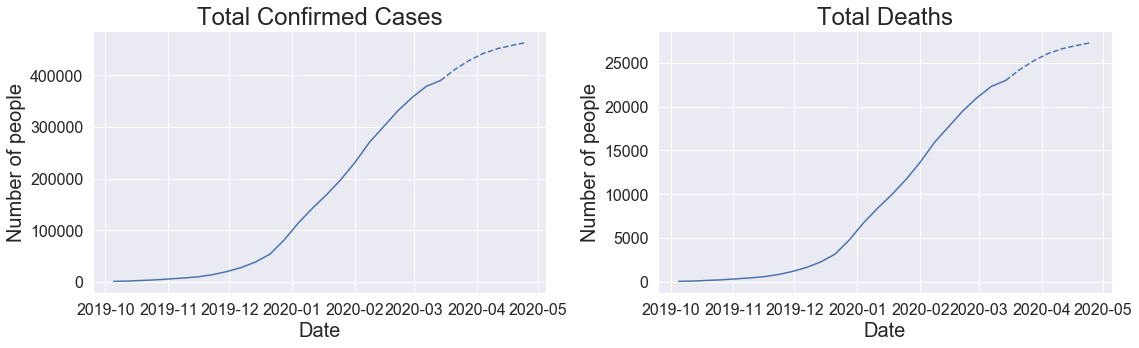

In [11]:
# Linear scale figure
# Figure settings
legible_graph(16, 5)

# Plot cumulative cases and deaths over time on linear scale
plt.subplot(1, 2, 1)
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE NUM']].iloc[:24], 'b')
plt.plot(current_year[['DATE']].iloc[23:], current_year[['CUMULATIVE NUM']].iloc[23:], 'b--')
set_labels('Total Confirmed Cases', 'Date', 'Number of people')

plt.subplot(1, 2, 2)
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE DEATH']].iloc[:24], 'b')
plt.plot(current_year[['DATE']].iloc[23:], current_year[['CUMULATIVE DEATH']].iloc[23:], 'b--')
set_labels('Total Deaths', 'Date', 'Number of people')
plt.tight_layout()

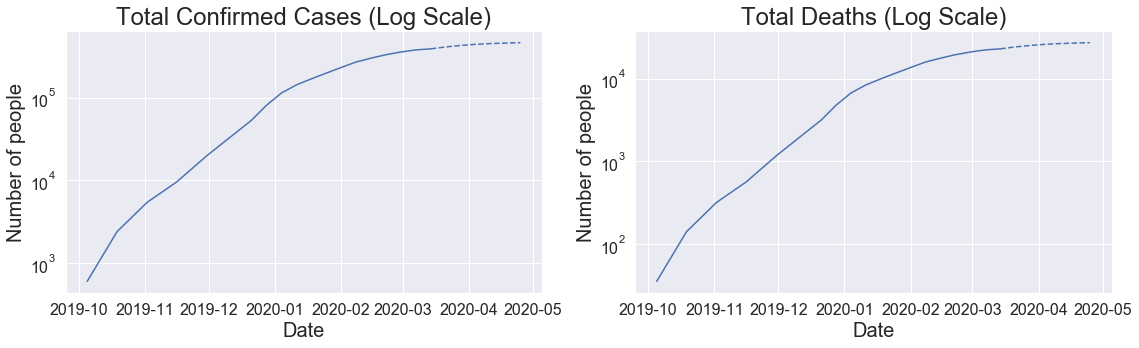

In [12]:
# Log scale figure
# Figure settings
legible_graph(16, 5)

# Plot cumulative cases and deaths over time on log scale
plt.subplot(1, 2, 1)
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE NUM']].iloc[:24], 'b', )
plt.plot(current_year[['DATE']].iloc[23:], current_year[['CUMULATIVE NUM']].iloc[23:], 'b--')
set_labels('Total Confirmed Cases (Log Scale)', 'Date', 'Number of people', logy=True)

plt.subplot(1, 2, 2)
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE DEATH']].iloc[:24], 'b')
plt.plot(current_year[['DATE']].iloc[23:], current_year[['CUMULATIVE DEATH']].iloc[23:], 'b--')
set_labels('Total Deaths (Log Scale)', 'Date', 'Number of people', logy=True)
plt.tight_layout()

# Plots comparing flu to COVID-19
- Cases and deaths over time on linear scale
- Cases and deaths over time on log scale
- More on COVID-19 data preparation and analysis can be found here: https://github.com/AMWen/COVID-19/blob/master/COVID-19.ipynb

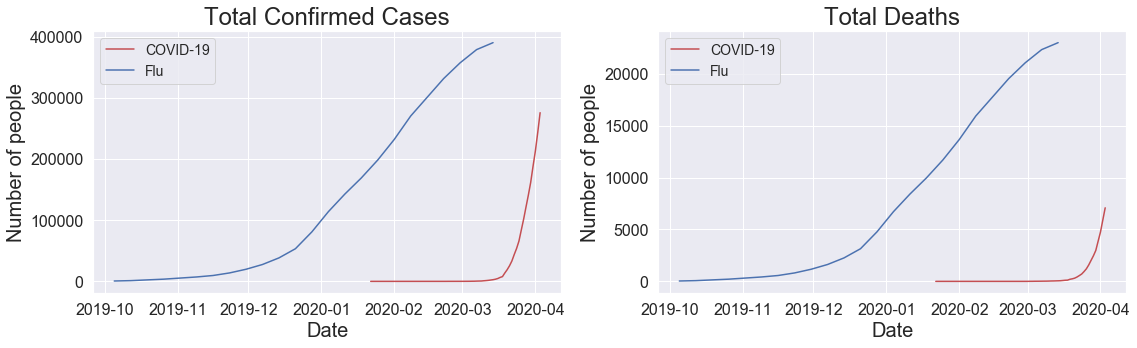

In [13]:
# Linear scale figure
# Load processed confirmed cases and deaths data
# Source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
covid_cases = pd.read_csv("time_series_covid19_confirmed_selected.csv").rename(columns={'Unnamed: 0':'Date'})
covid_deaths = pd.read_csv("time_series_covid19_deaths_selected.csv").rename(columns={'Unnamed: 0':'Date'})

# Convert 'Date' to a datetime object
covid_cases['Date'] = pd.to_datetime(covid_cases['Date'])
covid_deaths['Date'] = pd.to_datetime(covid_deaths['Date'])

# Figure settings
legible_graph(16, 5)

# Plot total cases and deaths over time on linear scale
plt.subplot(1, 2, 1)
plt.plot(covid_cases[['Date']].iloc[:], covid_cases[['US']].iloc[:], 'r', label='COVID-19')
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE NUM']].iloc[:24], 'b', label='Flu')
set_labels('Total Confirmed Cases', 'Date', 'Number of people')
plt.legend(loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(covid_deaths[['Date']].iloc[:], covid_deaths[['US']].iloc[:], 'r', label='COVID-19')
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE DEATH']].iloc[:24], 'b', label='Flu')
set_labels('Total Deaths', 'Date', 'Number of people')
plt.legend(loc="upper left")
plt.tight_layout()

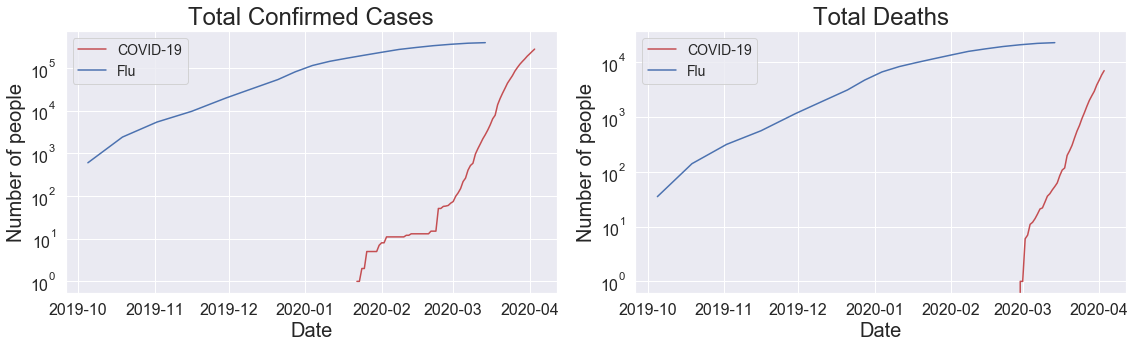

In [14]:
# Log scale figure
# Figure settings
legible_graph(16, 5)

# Plot total cases and deaths over time on log scale
plt.subplot(1, 2, 1)
plt.plot(covid_cases[['Date']].iloc[:], covid_cases[['US']].iloc[:], 'r', label='COVID-19')
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE NUM']].iloc[:24], 'b', label='Flu')
set_labels('Total Confirmed Cases', 'Date', 'Number of people', logy=True)
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(covid_deaths[['Date']].iloc[:], covid_deaths[['US']].iloc[:], 'r', label='COVID-19')
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE DEATH']].iloc[:24], 'b', label='Flu')
set_labels('Total Deaths', 'Date', 'Number of people', logy=True)
plt.legend(loc='upper left')
plt.tight_layout()

# What if COVID-19 continues with current trajectories?
- Estimating about 2x increase in cases every 3 days

In [15]:
# Get number of rows and latest date
nrows = covid_cases.index[-1]
latest_date = covid_cases[['Date']].iloc[-1:].values[0,0]
latest_date_plus3 = np.datetime_as_string(latest_date + np.timedelta64(3, 'D'), unit='D')
latest_date_plus6 = np.datetime_as_string(latest_date + np.timedelta64(6, 'D'), unit='D')

# Extrapolating every 3 days out to May
date_range_3 = pd.date_range(start=latest_date_plus3, end="2020-05-01", freq='3D')
date_range_6 = pd.date_range(start=latest_date_plus6, end="2020-05-01", freq='6D')

# Get current caseload and deaths
latest_cases = covid_cases[['US']].iloc[-1:].values[0,0]
latest_death = covid_deaths[['US']].iloc[-1:].values[0,0]

# Projecting case doubling every 6 days
ndays = len(date_range_6)
case_range = [2**i*latest_cases for i in range(1,ndays+1)]
df_temp = pd.DataFrame({'Date':[*date_range_6], 'US':case_range})
cases_extrapolated = covid_cases[['Date', 'US']].append(df_temp, ignore_index=True)

# Deaths doubling every 3 days
ndays = len(date_range_3)
death_range = [2**i*latest_death for i in range(1,ndays+1)]
df_temp = pd.DataFrame({'Date':[*date_range_3], 'US':death_range})
deaths_extrapolated = covid_deaths[['Date', 'US']].append(df_temp, ignore_index=True)

In [16]:
# Save results from 3/27 for future benchmarking
# cases_extrapolated.to_csv(r'cases_extrapolated_20200327_65rows.csv')
old_cases_extrapolated = pd.read_csv('cases_extrapolated_20200327_65rows.csv').drop('Unnamed: 0', axis=1)
# deaths_extrapolated.to_csv(r'deaths_extrapolated_20200327_65rows.csv')
old_deaths_extrapolated = pd.read_csv('deaths_extrapolated_20200327_65rows.csv').drop('Unnamed: 0', axis=1)

# Convert 'Date' to a datetime object
old_cases_extrapolated['Date']= pd.to_datetime(old_cases_extrapolated['Date'])
old_deaths_extrapolated['Date']= pd.to_datetime(old_deaths_extrapolated['Date'])

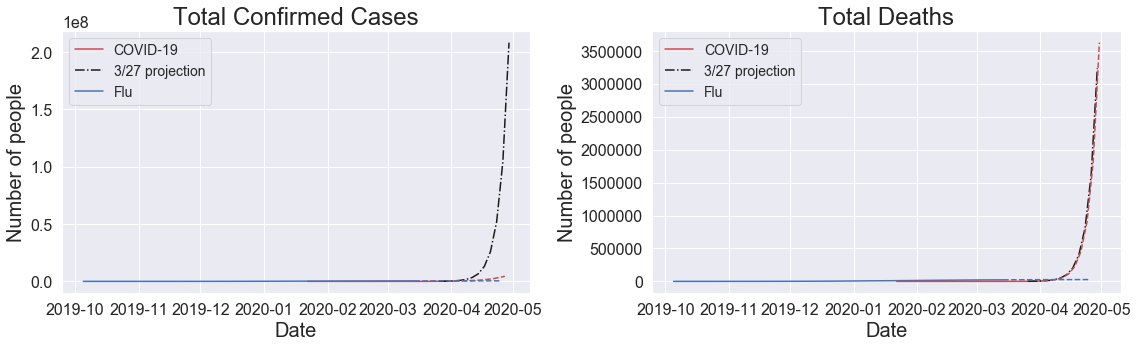

In [17]:
# Linear scale figure
# Figure settings
legible_graph(16, 5)

# Plot total cases and deaths over time on linear scale
plt.subplot(1, 2, 1)
plt.plot(cases_extrapolated[['Date']].iloc[:nrows], cases_extrapolated[['US']].iloc[:nrows], 'r', label='COVID-19')
plt.plot(old_cases_extrapolated[['Date']].iloc[64:], old_cases_extrapolated[['US']].iloc[64:], 'k-.', label='3/27 projection')
plt.plot(cases_extrapolated[['Date']].iloc[nrows-1:], cases_extrapolated[['US']].iloc[nrows-1:], 'r--')
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE NUM']].iloc[:24], 'b', label='Flu')
plt.plot(current_year[['DATE']].iloc[23:], current_year[['CUMULATIVE NUM']].iloc[23:], 'b--')
set_labels('Total Confirmed Cases', 'Date', 'Number of people')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(deaths_extrapolated[['Date']].iloc[:nrows], deaths_extrapolated[['US']].iloc[:nrows], 'r', label='COVID-19')
plt.plot(old_deaths_extrapolated[['Date']].iloc[64:], old_deaths_extrapolated[['US']].iloc[64:], 'k-.', label='3/27 projection')
plt.plot(deaths_extrapolated[['Date']].iloc[nrows-1:], deaths_extrapolated[['US']].iloc[nrows-1:], 'r--')
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE DEATH']].iloc[:24], 'b', label='Flu')
plt.plot(current_year[['DATE']].iloc[23:], current_year[['CUMULATIVE DEATH']].iloc[23:], 'b--')
set_labels('Total Deaths', 'Date', 'Number of people')
plt.legend(loc='upper left')
plt.tight_layout()

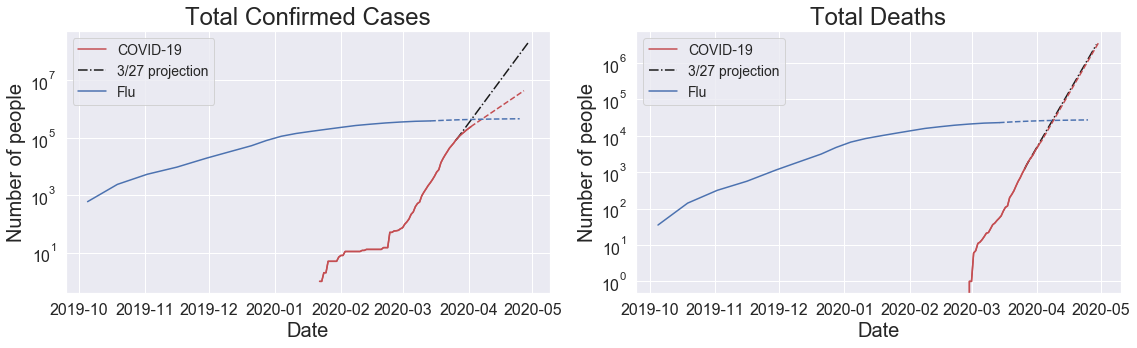

In [18]:
# Log scale figure
# Figure settings
legible_graph(16, 5)

# Plot total cases and deaths over time on linear scale
plt.subplot(1, 2, 1)
plt.plot(cases_extrapolated[['Date']].iloc[:nrows], cases_extrapolated[['US']].iloc[:nrows], 'r', label='COVID-19')
plt.plot(old_cases_extrapolated[['Date']].iloc[64:], old_cases_extrapolated[['US']].iloc[64:], 'k-.', label='3/27 projection')
plt.plot(cases_extrapolated[['Date']].iloc[:nrows], cases_extrapolated[['US']].iloc[:nrows], 'r')
plt.plot(cases_extrapolated[['Date']].iloc[nrows-1:], cases_extrapolated[['US']].iloc[nrows-1:], 'r--')
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE NUM']].iloc[:24], 'b', label='Flu')
plt.plot(current_year[['DATE']].iloc[23:], current_year[['CUMULATIVE NUM']].iloc[23:], 'b--')
set_labels('Total Confirmed Cases', 'Date', 'Number of people', logy=True)
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(deaths_extrapolated[['Date']].iloc[:nrows], deaths_extrapolated[['US']].iloc[:nrows], 'r', label='COVID-19')
plt.plot(old_deaths_extrapolated[['Date']].iloc[64:], old_deaths_extrapolated[['US']].iloc[64:], 'k-.', label='3/27 projection')
plt.plot(deaths_extrapolated[['Date']].iloc[:nrows], deaths_extrapolated[['US']].iloc[:nrows], 'r')
plt.plot(deaths_extrapolated[['Date']].iloc[nrows-1:], deaths_extrapolated[['US']].iloc[nrows-1:], 'r--')
plt.plot(current_year[['DATE']].iloc[:24], current_year[['CUMULATIVE DEATH']].iloc[:24], 'b', label='Flu')
plt.plot(current_year[['DATE']].iloc[23:], current_year[['CUMULATIVE DEATH']].iloc[23:], 'b--')
set_labels('Total Deaths', 'Date', 'Number of people', logy=True)
plt.legend(loc='upper left')
plt.tight_layout()